<a href="https://colab.research.google.com/github/mahdi943/Resnet-tumor-classifier/blob/master/Resnet_Full_Training_brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from numpy import random

import keras
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, BatchNormalization,Activation, Flatten, GlobalAveragePooling2D, SeparableConv2D
from keras.models import Model
from sklearn.metrics import accuracy_score
from sklearn import metrics
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.layers import Dropout
from keras.regularizers import l2
from keras.regularizers import l1

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os
from keras.utils.np_utils import to_categorical
from PIL import Image
np.random.seed(5)
from keras.preprocessing.image import load_img,img_to_array,array_to_img,save_img

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset/Train.zip"
!unzip "/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset/Test.zip"
!unzip "/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset/Valid.zip"

y_col = ['Class0', 'Class1']

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet152
from keras.applications.vgg16 import VGG16

base_model = ResNet152(weights = 'imagenet', include_top = False, input_shape=(500, 500, 3))

base_model.layers.pop()
base_model.layers.pop()
base_model.layers.pop()
base_model.layers.pop()

last_few_layers = 4
# for layer in base_model.layers[:-last_few_layers]:
for layer in base_model.layers:
    layer.trainable = False

# base_model.summary()

In [8]:
def brain_model(base_model, img_shape = (500,500,3)):
    
    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=img_shape) 
    
    # Forward pass to get the output of the last pooling layer
    X = base_model(inputs)
    X = GlobalAveragePooling2D()(X)
    X = Dropout(.25)(X)

    # Define the new binary classification head 
    X = Dense(1024, activation='relu', name='fc1')(X)
    X = Dropout(.5)(X)
    X = Dense(512, activation='relu', name='fc2')(X)
    X = Dropout(.5)(X)
    X = Dense(256, activation='relu', name='fc3')(X)
    X = Dropout(.5)(X)
    X = Dense(128, activation='relu', name='fc4')(X)
    X = Dropout(.5)(X)
    X = Dense(64, activation='relu', name='fc5')(X)
    X = Dropout(.5)(X)
        
    outputs = Dense(2,activation='softmax', name='Predictions')(X)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [9]:
model1 = brain_model (base_model, img_shape = (500,500,3))


dataclass1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset/labelTrain1.csv') 
data1class1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset/labelValid1.csv')
data2class1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset/labelTest1.csv')
data3class1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset/labelTestfinal.csv')

batch_size = 16

data_path = "/content/Train" 

dataclass1 = dataclass1.sample(frac=1)
dataclass1.reset_index(drop = True, inplace = True)

train_aug = ImageDataGenerator(	rescale=1/255.0,	
                              #  width_shift_range=[-100,100], 
                              #  height_shift_range=0.5,       
                               shear_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               rotation_range=90,
                               brightness_range=[0.2,0.05],
                               zoom_range=0.2
                               )

valid_datagen = ImageDataGenerator(rescale=1./255)
test_aug = ImageDataGenerator(rescale=1./255)

train_generator = train_aug.flow_from_dataframe(
    dataframe=dataclass1,
    directory=data_path,
    x_col='Image',
    y_col= y_col,
    class_mode="raw",
    shuffle=True,
    target_size=(500,500), 
    batch_size=batch_size)

valid_generator = test_aug.flow_from_dataframe(
    dataframe=data1class1,
    directory="/content/Valid",
    x_col='Image',
    y_col= y_col,
    class_mode= "raw",
    target_size=(500,500),
    batch_size=batch_size
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model1.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model1.fit(train_generator, batch_size= 16 ,epochs=20, validation_data = valid_generator, callbacks= callback)

print('\nTest generator:\n')

test_generator1 = test_aug.flow_from_dataframe(
    dataframe=data2class1,
    directory="/content/Test",
    x_col='Image',
    y_col= y_col,
    shuffle=True,
    class_mode= "raw",
    target_size=(500,500),
    batch_size=batch_size
)

y_predict = model1.predict(test_generator1)
y_predict = y_predict.argmax(-1)
accuracy_score(data3class1['label'],y_predict)
    


Found 256 validated image filenames.
Found 64 validated image filenames.
Epoch 1/20
16/16 [==============================] - 34s 2s/step - loss: 1.6277 - accuracy: 0.5820 - val_loss: 0.7414 - val_accuracy: 0.7500
Epoch 2/20
16/16 [==============================] - 24s 1s/step - loss: 1.3547 - accuracy: 0.6406 - val_loss: 0.5619 - val_accuracy: 0.7500
Epoch 3/20
16/16 [==============================] - 23s 1s/step - loss: 1.1653 - accuracy: 0.6172 - val_loss: 0.5602 - val_accuracy: 0.7500
Epoch 4/20
16/16 [==============================] - 23s 1s/step - loss: 0.9362 - accuracy: 0.6250 - val_loss: 0.5799 - val_accuracy: 0.7500
Epoch 5/20
16/16 [==============================] - 22s 1s/step - loss: 0.8737 - accuracy: 0.6250 - val_loss: 0.5959 - val_accuracy: 0.7500
Epoch 6/20
16/16 [==============================] - 22s 1s/step - loss: 0.7596 - accuracy: 0.6484 - val_loss: 0.5910 - val_accuracy: 0.7500
Epoch 7/20
16/16 [==============================] - 22s 1s/step - loss: 0.7511 - accura

0.75

In [10]:
model2 = brain_model (base_model, img_shape = (500,500,3))

dataclass2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset-class2/labelTrain-class2.csv') 
data1class2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset-class2/labelValid-class2.csv')
data2class2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset-class2/labelTest-class2.csv')
data3class2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset-class2/labelTestfinal-class2.csv')


batch_size = 16

data_path = "/content/Train" 

#shuffle the data
dataclass2 = dataclass2.sample(frac=1)
dataclass2.reset_index(drop = True, inplace = True)

train_aug = ImageDataGenerator(	rescale=1/255.0,	
                               shear_range=0.2,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               rotation_range=90,
                               brightness_range=[0.2,0.02],
                               zoom_range=0.2,
                               )  


valid_datagen = ImageDataGenerator(rescale=1./255)
test_aug = ImageDataGenerator(rescale=1./255)

train_generator = train_aug.flow_from_dataframe(
    dataframe=dataclass2,
    directory=data_path,
    x_col='Image',
    y_col= y_col,
    class_mode="raw",
    shuffle=True,
    target_size=(500,500), 
    batch_size=batch_size)

valid_generator = test_aug.flow_from_dataframe(
    dataframe=data1class2,
    directory="/content/Valid",
    x_col='Image',
    y_col= y_col,
    class_mode= "raw",
    target_size=(500,500),
    batch_size=batch_size
)

# from tensorflow.keras.optimizers import SGD
# opt = SGD(learning_rate=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
# optimizer = tf.keras.optimizers.Adam(lr=0.001)
model2.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model2.fit(train_generator, batch_size= 16 ,epochs=25, validation_data = valid_generator, callbacks= callback)

print('\nTest generator:\n')

test_generator2 = test_aug.flow_from_dataframe(
    dataframe=data2class2,
    directory="/content/Test",
    x_col='Image',
    y_col= y_col,
    shuffle=True,
    class_mode= "raw",
    target_size=(500,500),
    batch_size=batch_size
)

y_predict = model2.predict(test_generator2)
y_predict = y_predict.argmax(-1)
accuracy_score(data3class2['label'],y_predict)
    



Found 256 validated image filenames.
Found 64 validated image filenames.
Epoch 1/25
16/16 [==============================] - 33s 2s/step - loss: 2.0665 - accuracy: 0.5586 - val_loss: 0.8189 - val_accuracy: 0.7500
Epoch 2/25
16/16 [==============================] - 22s 1s/step - loss: 1.7778 - accuracy: 0.5938 - val_loss: 0.6380 - val_accuracy: 0.7500
Epoch 3/25
16/16 [==============================] - 22s 1s/step - loss: 1.3122 - accuracy: 0.6055 - val_loss: 0.5655 - val_accuracy: 0.7500
Epoch 4/25
16/16 [==============================] - 22s 1s/step - loss: 1.0645 - accuracy: 0.6172 - val_loss: 0.5664 - val_accuracy: 0.7500
Epoch 5/25
16/16 [==============================] - 24s 1s/step - loss: 0.9631 - accuracy: 0.6172 - val_loss: 0.6260 - val_accuracy: 0.7500
Epoch 6/25
16/16 [==============================] - 23s 1s/step - loss: 0.7694 - accuracy: 0.6406 - val_loss: 0.6084 - val_accuracy: 0.7500
Epoch 7/25
16/16 [==============================] - 23s 1s/step - loss: 0.7168 - accura

0.75

In [12]:
model3 = brain_model (base_model, img_shape = (500,500,3))

dataclass3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset-class3/labelTrain-class3.csv') 
data1class3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset-class3/labelValid-class3.csv')
data2class3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset-class3/labelTest-class3.csv')
data3class3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset-class3/labelTestfinal-class3.csv')
dataTestFinal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset/test_brain.csv')

batch_size = 16

data_path = "/content/Train" 

#shuffle the data
dataclass3 = dataclass3.sample(frac=1)
dataclass3.reset_index(drop = True, inplace = True)

train_aug = ImageDataGenerator(	rescale=1/255.0,	     
                               shear_range=0.2,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               rotation_range=90,
                               brightness_range=[0.2,0.02],
                               zoom_range=0.2,
                               )                               
                              #  rotation_range=20,	
                              #  zoom_range=0.05,	
                              #  width_shift_range=0.1,	
                              #  height_shift_range=0.1,	
                              #  shear_range=0.05,	
                              #  horizontal_flip=True,	
                              #  vertical_flip=True,	
                              #  fill_mode="nearest"
                              #  )


valid_datagen = ImageDataGenerator(rescale=1./255)
test_aug = ImageDataGenerator(rescale=1./255)

train_generator = train_aug.flow_from_dataframe(
    dataframe=dataclass3,
    directory=data_path,
    x_col='Image',
    y_col= y_col,
    class_mode="raw",
    shuffle=True,
    target_size=(500,500), 
    batch_size=batch_size)

valid_generator = test_aug.flow_from_dataframe(
    dataframe=data1class3,
    directory="/content/Valid",
    x_col='Image',
    y_col= y_col,
    class_mode= "raw",
    target_size=(500,500),
    batch_size=batch_size
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# opt = SGD(learning_rate=1e-3, decay=1e-6, momentum=0.8, nesterov=True)

model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model3.fit(train_generator, batch_size= 32, epochs=25, validation_data = valid_generator, callbacks= callback)


print('test generator:\n')
test_generator3 = test_aug.flow_from_dataframe(
    dataframe=data2class3,
    directory="/content/Test",
    x_col='Image',
    y_col= y_col,
    shuffle=True,
    class_mode= "raw",
    target_size=(500,500),
    batch_size=batch_size
)

y_predict = model3.predict(test_generator3)
y_predict = y_predict.argmax(-1)
accuracy_score(data3class3['label'],y_predict)
    



Found 256 validated image filenames.
Found 64 validated image filenames.
Epoch 1/25
16/16 [==============================] - 52s 2s/step - loss: 1.6336 - accuracy: 0.6172 - val_loss: 0.5800 - val_accuracy: 0.7500
Epoch 2/25
16/16 [==============================] - 23s 1s/step - loss: 1.6977 - accuracy: 0.6484 - val_loss: 0.5771 - val_accuracy: 0.7500
Epoch 3/25
16/16 [==============================] - 24s 1s/step - loss: 1.4247 - accuracy: 0.5664 - val_loss: 0.6652 - val_accuracy: 0.7500
Epoch 4/25
16/16 [==============================] - 23s 1s/step - loss: 1.0616 - accuracy: 0.6445 - val_loss: 0.6134 - val_accuracy: 0.7500
Epoch 5/25
16/16 [==============================] - 23s 1s/step - loss: 0.8864 - accuracy: 0.6602 - val_loss: 0.6805 - val_accuracy: 0.7500
Epoch 6/25
16/16 [==============================] - 23s 1s/step - loss: 0.8539 - accuracy: 0.6367 - val_loss: 0.6315 - val_accuracy: 0.7500
Epoch 7/25
16/16 [==============================] - 23s 1s/step - loss: 0.7956 - accura

0.75

In [13]:
model4 = brain_model (base_model, img_shape = (500,500,3))

dataclass4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset-class4/labelTrain-class4.csv') 
data1class4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset-class4/labelValid-class4.csv')
data2class4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset-class4/labelTest-class4.csv')
data3class4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset-class4/labelTestfinal-class4.csv')
dataTestFinal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS515 - project/dataset/dataset/test_brain.csv')

batch_size = 16

data_path = "/content/Train" 

#shuffle the data
dataclass4 = dataclass4.sample(frac=1)
dataclass4.reset_index(drop = True, inplace = True)

train_aug = ImageDataGenerator(	rescale=1/255.0,	     
                               shear_range=0.2,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               rotation_range=90,
                               brightness_range=[0.2,0.02],
                               zoom_range=0.2,
                               )                               
                              #  rotation_range=20,	
                              #  zoom_range=0.05,	
                              #  width_shift_range=0.1,	
                              #  height_shift_range=0.1,	
                              #  shear_range=0.05,	
                              #  horizontal_flip=True,	
                              #  vertical_flip=True,	
                              #  fill_mode="nearest"
                              #  )


valid_datagen = ImageDataGenerator(rescale=1./255)
test_aug = ImageDataGenerator(rescale=1./255)

train_generator = train_aug.flow_from_dataframe(
    dataframe=dataclass4,
    directory=data_path,
    x_col='Image',
    y_col= y_col,
    class_mode="raw",
    shuffle=True,
    target_size=(500,500), 
    batch_size=batch_size)

valid_generator = test_aug.flow_from_dataframe(
    dataframe=data1class4,
    directory="/content/Valid",
    x_col='Image',
    y_col= y_col,
    class_mode= "raw",
    target_size=(500,500),
    batch_size=batch_size
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# opt = SGD(learning_rate=1e-3, decay=1e-6, momentum=0.8, nesterov=True)

model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model4.fit(train_generator, batch_size= 16, epochs=20, validation_data = valid_generator, callbacks= callback)


print('test generator:\n')
test_generator4 = test_aug.flow_from_dataframe(
    dataframe=data2class4,
    directory="/content/Test",
    x_col='Image',
    y_col= y_col,
    shuffle=True,
    class_mode= "raw",
    target_size=(500,500),
    batch_size=batch_size
)

y_predict = model4.predict(test_generator3)
y_predict = y_predict.argmax(-1)
accuracy_score(data3class4['label'],y_predict)
    



Found 256 validated image filenames.
Found 64 validated image filenames.
Epoch 1/20
16/16 [==============================] - 33s 2s/step - loss: 2.1831 - accuracy: 0.6133 - val_loss: 0.7319 - val_accuracy: 0.2500
Epoch 2/20
16/16 [==============================] - 22s 1s/step - loss: 1.6248 - accuracy: 0.5898 - val_loss: 0.5824 - val_accuracy: 0.7500
Epoch 3/20
16/16 [==============================] - 23s 1s/step - loss: 1.1125 - accuracy: 0.6680 - val_loss: 0.5829 - val_accuracy: 0.7500
Epoch 4/20
16/16 [==============================] - 22s 1s/step - loss: 0.9898 - accuracy: 0.6758 - val_loss: 0.5805 - val_accuracy: 0.7500
Epoch 5/20
16/16 [==============================] - 22s 1s/step - loss: 0.9060 - accuracy: 0.6523 - val_loss: 0.6089 - val_accuracy: 0.7500
Epoch 6/20
16/16 [==============================] - 22s 1s/step - loss: 0.7755 - accuracy: 0.6523 - val_loss: 0.6261 - val_accuracy: 0.7500
Epoch 7/20
16/16 [==============================] - 22s 1s/step - loss: 0.7377 - accura

0.75

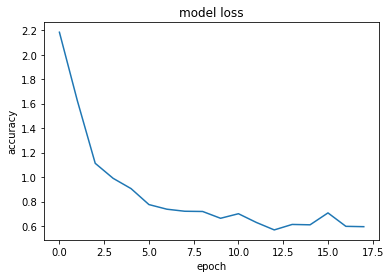

In [14]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

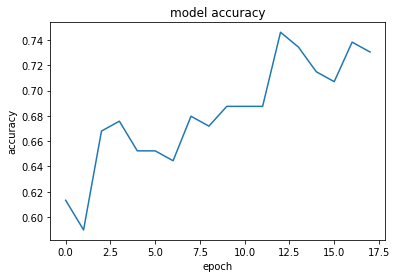

In [15]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [16]:
y_predict1 = model1.predict(test_generator1)
y_predict1 = y_predict1.argmax(-1)

y_predict2 = model2.predict(test_generator2)
y_predict2 = y_predict2.argmax(-1)

y_predict3 = model3.predict(test_generator3)
y_predict3 = y_predict3.argmax(-1)

y_predict4 = model4.predict(test_generator3)
y_predict4 = y_predict4.argmax(-1)

final_predict = np.zeros((79,1))

for i in range(79):

  if y_predict4[i] == 1:
    final_predict[i] = 3
  
  elif y_predict3[i] == 1:
    final_predict[i] = 2 
  
  elif y_predict2[i] == 1:
    final_predict[i] = 1
  
  else:
    final_predict[i] = 0





In [17]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

accuracy_score(dataTestFinal['label'],final_predict)
    


0.24050632911392406